In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima

import seaborn as sns

In [2]:
#Function to get specific columns of data from the data frame
def get_certain_columns(df, columns):
    return df[columns]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.41437e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


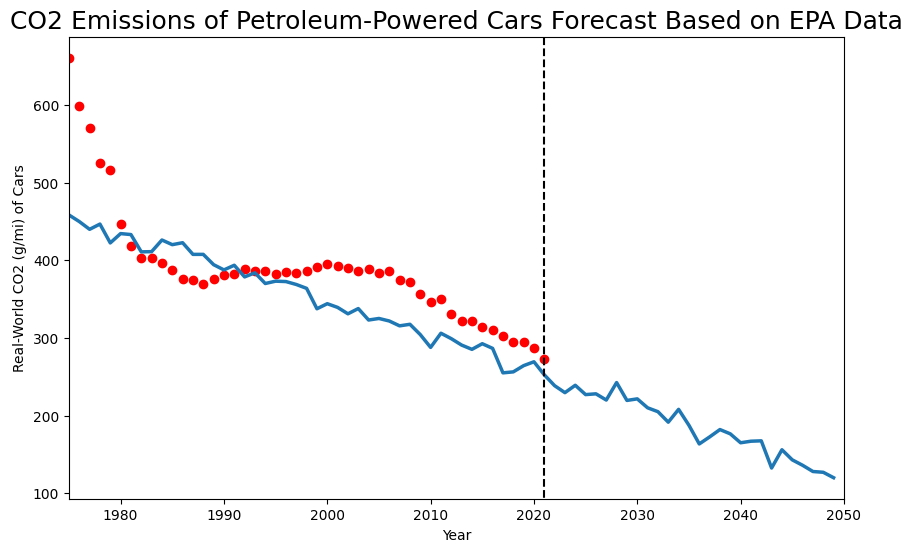

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.41437e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


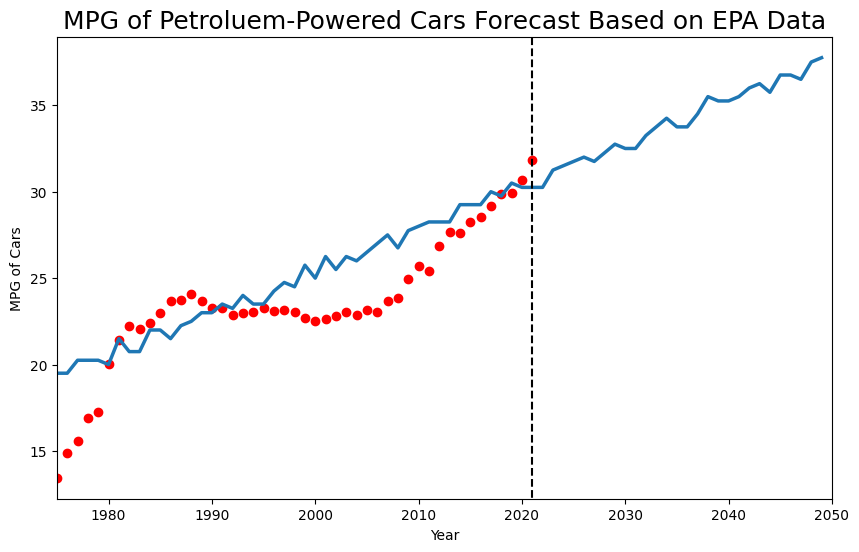

In [3]:
#Reading EPA Automotive Trends Report Database
data_EPA = pd.read_csv('United States Environmental Protection Agency – Automotive Trends Report.csv')

#Function that creates a graph for a specific vehicle type and a specific metric(column)
def get_specific_EPAgraph(vehicle_type, index, column, title, xlabel, ylabel):
    specific_data = pd.DataFrame(data_EPA.loc[data_EPA['Vehicle Type'] == vehicle_type].values.tolist())
    specific_data.columns = data_EPA.columns
    specific_data = specific_data[[index, column]]
    specific_data.set_index(index, inplace=True)
    specific_data = specific_data.iloc[:-1,:]
    yearsarray = np.array([int(i) for i in specific_data.index])
    x = yearsarray
    y_in = specific_data
    x_pred = []
    for i in range(1975,2050):
        x_pred.append(i)
    poly_features = x.reshape(-1,1)
    poly_reg_model = KernelRidge(alpha = 0.05, kernel = "polynomial", degree = 2)
    poly_reg_model.fit(poly_features, y_in)
    y_predicted = poly_reg_model.predict(poly_features)
    x_new = np.array(x_pred).reshape(-1,1)
    pred_new = poly_reg_model.predict(x_new)
    plt.figure(figsize=(10,6))
    plt.title(title, size=18)
    plt.plot(x_new, pred_new, linewidth = 2.5)
    plt.scatter(x, y_in, color = 'red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(x=2021, ymin=-2.5, ymax = 9, color = 'black', linestyle = '--')
    plt.xlim([1975,2050])
    plt.ylim([0,1000])
    plt.autoscale(enable=True, axis='y', tight=False)
    plt.show()

#Calling the function for graphs of specific vehicle type and specific metric
index = 'Model Year'
get_specific_EPAgraph('All Car', index, 'Real-World CO2 (g/mi)', 'CO2 Emissions of Petroleum-Powered Cars Forecast Based on EPA Data', 'Year', 'Real-World CO2 (g/mi) of Cars')
get_specific_EPAgraph('All Car', index, 'Real-World MPG', 'MPG of Petroluem-Powered Cars Forecast Based on EPA Data', 'Year', 'MPG of Cars')


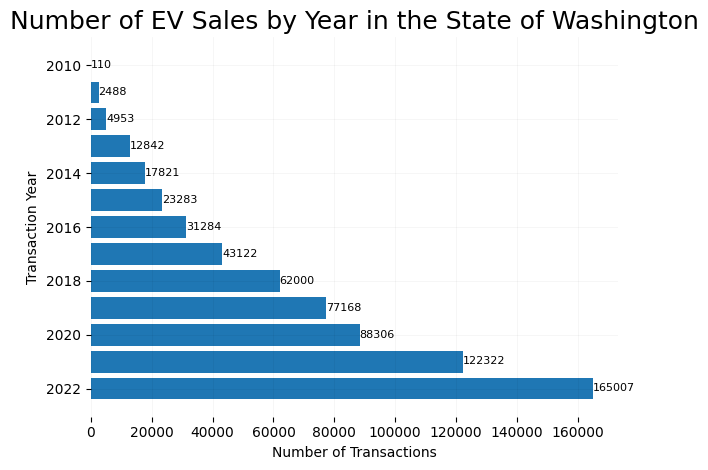

In [4]:
#Reading State of Washington Electric Vehicle Title and Registration Activity Database
data_WA_registration = pd.read_csv('State of Washington - Electric Vehicle Title and Registration Activity.csv')

#Calling function to get the column of Transaction Year
transaction_years = get_certain_columns(data_WA_registration, ['Transaction Year'])

#Finding unique years in the Transaction Year column
unique = {}
for number in transaction_years['Transaction Year'].unique():
    if number != 2023:
        unique[number] = transaction_years['Transaction Year'].value_counts()[number]

#Plotting a bar plot of the unique years and number of transactions per year
plt.barh(list(unique.keys()), list(unique.values()))

##Adding values to the bar plot
for i in plt.gca().patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(i.get_width()), fontsize=8)
    
#Formatting the plot
for s in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[s].set_visible(False)
plt.gca().grid(visible=True, color = 'black', linestyle='-', linewidth=0.5, alpha=0.05)
plt.gca().invert_yaxis()
plt.ylabel('Transaction Year')
plt.xlabel('Number of Transactions')
plt.title('Number of EV Sales by Year in the State of Washington', size=18)
plt.tight_layout()

plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1448\3533659200.py:5: DtypeWarning: Columns (7,16,62,64,65,67,68,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data_EPA1 = pd.read_csv('United States Environmental Protection Agency - Vehicle Fuel Economy Estimates.csv')


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=601.575, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=601.623, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=598.912, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=601.732, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=585.000, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=585.736, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=586.338, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=584.575, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=598.626, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=585.448, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=586.051, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.28 se

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


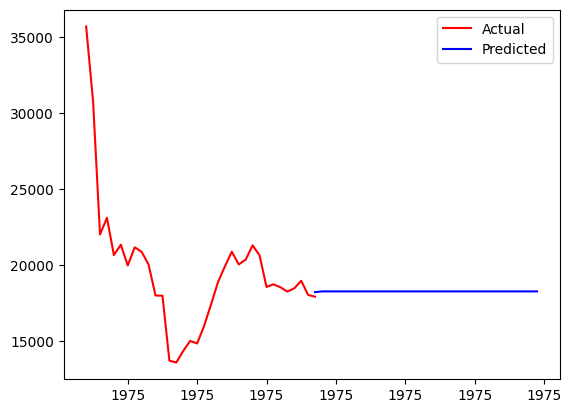

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.81104e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


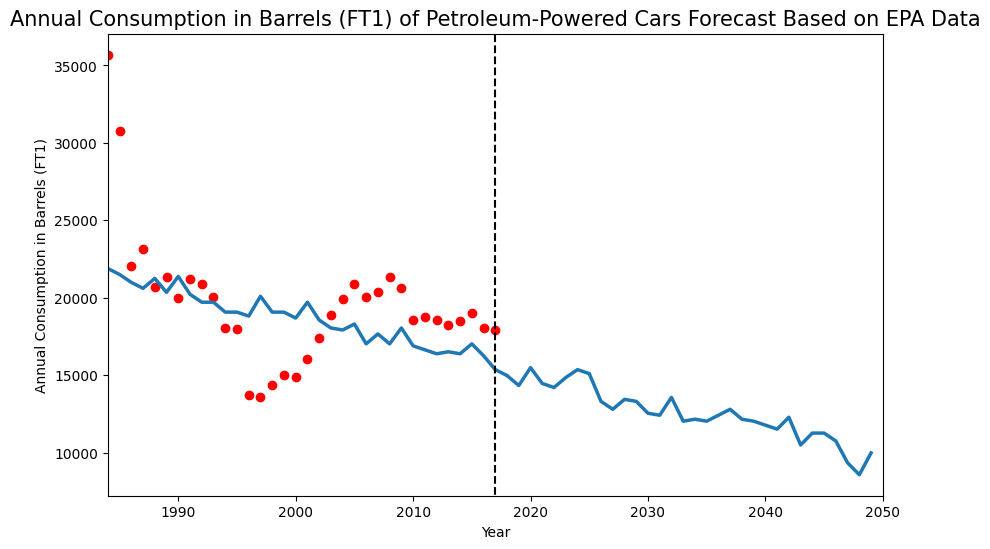

In [5]:
from enum import auto
from tracemalloc import start


data_EPA1 = pd.read_csv('United States Environmental Protection Agency - Vehicle Fuel Economy Estimates.csv')
def gas_only(name):
    if('Electricity' in name):
        return False
    if(('propane' in name) or ('CNG' in name) or ('natural gas' in name)):
        return False
    return True

gas = pd.DataFrame(data_EPA1.loc[data_EPA1['Fuel Type'].apply(gas_only)].values.tolist())
gas.columns = data_EPA1.columns
gas = gas.loc[gas['Annual Consumption in Barrels (FT1)'] != '0']
gas = get_certain_columns(gas, ['Year', 'Annual Consumption in Barrels (FT1)'])
unique_values = {}
unique_years = gas['Year'].unique().tolist()
unique_years.sort()
for i in unique_years:
    unique_values[i] = gas.groupby('Year').get_group(i)['Annual Consumption in Barrels (FT1)'].sum()
df_dict = {'Year' : unique_values.keys(), 'Annual Consumption in Barrels (FT1)' : unique_values.values()}
gas = pd.DataFrame(df_dict)
gas.set_index('Year', inplace=True)
train = gas
test = gas

model = auto_arima(train['Annual Consumption in Barrels (FT1)'], start_p=1, start_q=1,max_p=5, max_q=5,d=1,max_d=2,seasonal=False, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)
future_x = []
for i in range(2017,2050):
    future_x.append(i)
pred = model.predict(n_periods=len(future_x))
#rmse = np.sqrt(mean_squared_error(test['Annual Consumption in Barrels (FT1)'], pred))
#print(f'RMSE: {rmse}')

plt.plot(test.index, test['Annual Consumption in Barrels (FT1)'], color='red', label='Actual')
plt.plot(future_x, pred, color='blue', label='Predicted')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.show()
"""
X = gas.index.values.reshape(-1,1)
Y = gas['Annual Consumption in Barrels (FT1)']
future_x = []
for i in range(1984,2050):
    future_x.append(i)
future_x = np.array(future_x).reshape(-1,1)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=50)
model = sklearn.ensemble.RandomForestRegressor()
model.fit(X_train, Y_train)
pred=model.predict(X_test)
rmse = mean_squared_error(Y_test, pred, squared = False)
print(f'RMSE: {rmse}')
forecasts = model.predict(future_x)
plt.plot(X, gas['Annual Consumption in Barrels (FT1)'], color='red', label='Actual')
plt.plot(future_x, forecasts, color='blue', label='Forecast')
plt.show()
"""

yearsarray = np.array([int(i) for i in gas.index])
x = yearsarray
y_in = gas
x_pred = []
for i in range(1984,2050):
    x_pred.append(i)
poly_features = x.reshape(-1,1)
poly_reg_model = KernelRidge(alpha = 0.05, kernel = "polynomial", degree = 2)
poly_reg_model.fit(poly_features, y_in)
y_predicted = poly_reg_model.predict(poly_features)
x_new = np.array(x_pred).reshape(-1,1)
pred_new = poly_reg_model.predict(x_new)
plt.figure(figsize=(10,6))
plt.title('Annual Consumption in Barrels (FT1) of Petroleum-Powered Cars Forecast Based on EPA Data', size=15)
plt.plot(x_new, pred_new, linewidth = 2.5)
plt.scatter(x, y_in, color = 'red')
plt.xlabel('Year')
plt.ylabel('Annual Consumption in Barrels (FT1)')
plt.axvline(x=2017, ymin=-2.5, ymax = 9, color = 'black', linestyle = '--')
plt.xlim([1984,2050])
plt.ylim([0,1000])
plt.autoscale(enable=True, axis='y', tight=False)
plt.show()
